In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from alibi_detect.cd import KSDrift

iris = load_iris()
X = iris.data
y = iris.target

#### Requirements

- alibi-detect==0.4.3
- matplotlib==3.3.3
- numpy == 1.9.3 (note: At the time of writing, numpy version 1.9.4 for Windows users is causing a few issues, which is why 1.9.3 is recommended here).
- seaborn==0.11.0
- scikit-learn==0.23.2

### KS Drift and model performance relationship

**Goal**: To look at the unsupervised Kolmogorov-Smirnov drift detection technique and discover how it can relate to the supervised model performance.

#### Why?

In order to go live with a machine learning model, everything should be done to ensure that the model is accurate enough and ready to be put into production. The best way to do this is by getting a model to predict on previously unseen labelled data* and recording a metric. Once performance on the test set is acceptable, a model can then be deployed into the wild.

However, once that model is in production, what then? While previously an afterthought in the machine learning world, with the surge in companies turning to machine learning solutions, the idea of model maintenance has become more important in recent years. You can deploy your model today based on data from last month, but will the data in 6 months follow the same distribution? Usually, the answer to this is no, and at some point a model will need retraining, which can largely be due to **drift** in the data.

Now, drift can be a confusing thing (even more-so than machine learning data sets talked about in the side remark!) as there are various types of drift and the terms can (again) sometimes be used interchangeably in literature! While I won't go too deep on this, we'll mostly be concerned with **input drift** which can sometimes be referred to as **covariate shift**. The put it in simple terms, this is saying that your input data for a model (your X data) now looks different than what it did in the training set, usually with a distribution shift.

As a simple example, imagine that you are training a model to detect credit card fraud. Over time we know the data will change - with one big example being inflation of prices. £30 today won't hold the same value as £30 in 5 years' time, thus we see an example of drift that can happen.

\***Side remark**: The names of data sets can be confusing due to past literature using terms interchangeably and also (in my opinion) due to the fact that the most popular method for splitting data is SKLearn's train test split method which creates two separate data sets. While out of scope for this notebook, it is worth pointing out that when training your model, you actually want to determine the best parameters for performance with a **validation set**, while your **test set** is data that your model never sees and is not tuned to - it is simply used to predict and record metrics for performance and is a final gate to sign off a model for production. The [Wikipedia](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets#Cross-validation "Wikipedia") entry explains a lot of this quite well, but keep in mind that validation and test can sometimes be used interchangeably and can get confusing.

On the last point about "not tuned to": this is ideal, but in practice not always possible for companies in the real world. You'll often find that many machine learning productions rely on thresholds of final metrics in the test sets to get sign off and, ultimately, get paid! Thus, it's not unheard of for companies to start tuning the parameters of the model to a test set (particularly if deadlines are coming up). This is not ideal, but if this situation does arise just make sure that the test set data is never used in training!

### Detecting drift - The Holy Grail of model monitoring

If we stick with input drift, the general idea is that a dataset distribution drifting will likely mean that the model is no longer performing how we want it to. So, we can just compare a new sample to our original training set sample periodically and then flag if we think that the data has changed that much that confidence in the model has dropped. This works under the simple theory that a model will always struggle to correctly determine data from distributions it is not familiar with.

It should be noted here that this is not the optimal way determine if your model is no longer performing well - the best method is to use a new labelled test data set. So why even do this? Well, the biggest factors are time and cost! If you've had any experience with machine learning projects, you'll understand that the data gathering aspect is one of the costliest aspects. Even crowdsourcing platforms like MTurk, while good, have their own problems in that label quality is not always assured.

This is why I referred to this as the Holy Grail - Machine learning practitioners want a way of flagging problems in their production models with minimal cost. Since input drift detection requires no labels, we get this.


#### Enter Alibi-Detect and Kolmogorov–Smirnov drift

The good people at [Seldon IO](https://www.seldon.io/ "Seldon") offer an open-source model monitoring platform known as [**alibi-detect**](https://github.com/SeldonIO/alibi-detect, "alibi-detect"). While they mostly offer solutions for outlier detection (another good way of monitoring models!), they also provide solutions for detecting drift. One of these is [**Kolmogorov–Smirnov (KS) drift detection**](https://docs.seldon.io/projects/alibi-detect/en/stable/methods/ksdrift.html "KS test"). A KS test is a well-established statistical test that compares two distributions and produces a p-value to tell you if they are drawn from the same distribution.

If you're not entirely sure what a [p value](https://en.wikipedia.org/wiki/P-value "p value") is, then don't worry too much, but it is simply producing a probability of your hypothesis. In terms of the KS test, this probability can be thought of as considering the hypothesis: "are these two data sets drawn from the same distribution?". What is important to know is that researchers often use p < 0.05 as a standard to determine if a result is "significant" (other values are commonly used as well, but just consider 0.05 for now). So, for example, say you have two sets of data which both have the heights of 100 people each. You put them both into a KS test and it returns 0.01. This is the equivalent of saying that there is only a 1% probability that the two sets of heights are drawn from the same distribution! So you reject the hypothesis.

You might be questioning: why use alibi-detect when [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html "SciPy") offer a perfectly good function for KS testing? The main reason is that most machine learning models have multiple features, sometimes thousands, and you'd have to apply a KS test for each one of these. Alibi-detect is able to aggregate every single p-value and, effectively, then produce a single figure that can tell you if drift is present or not. It aggregates using your choice of either Bonferroni or the False Discovery Rate correction. As with other things mentioned, you can investigate these, but it is not essential - just take it on faith that these are established methods to aggregate multiple p values!

#### Continuous and discrete warning!

If you're not familiar with a KS test, then it is used to compare two **continuous** distributions against each other, which can be any real number. Examples of continuous can include a person's height, a price in dollars or the temperature. This is opposed to **discrete variables** which can also be categorical - they take on a fixed number of values. Examples can include day of the week, shoe size or number of stars a planet has.

For discrete variable distributions, something like chi-square should be used instead. Therefore, if you want to adapt this to another data set, consider what variables you have!

If you do have a mixture then options can include adapting the alibi-detect code to use chi-square for categorical variables or converting your data to be entirely continuous, using something like PCA or a shall neural network embedding.

#### How does KS drift in Alibi-detect work (does it even work?)

So, as mentioned, Alibi-detect will compare your distributions. The idea is that you declare a "reference" data set (which will be the X data you used to train your model with) and then can predict on a new sample as to whether they look like they're from the same distribution. If yes, then it returns a drift detection value of 0, meaning they look like similar distributions. If no, then it returns a drift detection value of 1, meaning that the new distribution has "drifted" from the training reference data. And that's it! Alibi-detect gives you a simple 

This is ideal for production when you think about it. Imagine you've just gained good results on a test set and put your model live. The training data can then be set as your reference data. Then, at the end of each month, you can take a new sample (of the same size) and compare it to reference data. So, every month we'll get a binary figure to tell us if drift has been detected!

#### So, drift detection means my model is bad?

This is the big point of contention, and one aspect of all this is **what do you consider as an unacceptable drop in model performance?** Remember, without labels there is no way to get traditional metrics that are used in supervised monitoring; these metrics are often pivotal to models being deemed acceptable. For example, your model could have a precision score drop of 0.1, which is something that would usually be flagged as a problem for you, but no drift is detected. It's also not out of the question that KS drift could flag that drift has been detected, but metrics can still perform above a chosen threshold. There's no set of laws on what to do and **you always need to make the final decision on model evaluation**. You may very well find that drift detection just doesn't work for you and the metrics you need!

#### Unsupervised drift vs. supervised metrics

I've seen very little on the relationship of unsupervised drift detection methods and performance metrics, so it's something we can look at here. Some of the things I'm keen to look at are:

- On average, at what point is drift detection detected and how does that relate to metric performance?
- Do some models handle drift better than others?
- How do different types of noise impact drift and performance?

We want to gain the most efficiency with our model - so we want to pull it only at the time when it is no longer capable of making enough correct predictions. So we want to understand what it means for model performance when the KS test flags that there is drft.

#### First - a quick introduction to the KSDrift code

KSDrift works by giving the class some data it can use as its reference (or the desired distribution) and then "predicting" on new samples to determine if the new data has drifted.

Please note, when calling the class with the version I used for this notebook, it presumes that you will apply a preprocessing step, thus it may throw an error if you don't give it something. If this happens to you, and you just want to use the data without any preprocessing, then just use `fake_transform()` from below in your code. It may well be that this issue is solved in future versions though, so try without first!

We'll use Bonferroni correction throughout this to aggregate our p values - you can switch between this and false discovery rate in the class set up.

We show the output, which is a dictionary that includes a boolean flag, where 1 is drift detection and 0 is no drift detection. It will return the distance metrics computed as well as the individual p values for each feature (we'll introduce the `drift_type` parameter later).

In [231]:
def fake_transform(X):
    return X

cd = KSDrift(
    p_val=0.05,
    X_ref=X,
    preprocess_X_ref=False,
    preprocess_fn=fake_transform,
    alternative='two-sided',
    data_type="tabular",
)

cd.predict(X+0.0001)

{'data': {'is_drift': 1,
  'distance': array([0.06666667, 0.17333333, 0.08666667, 0.19333333], dtype=float32),
  'p_val': array([0.87056947, 0.01931273, 0.5954829 , 0.00625558], dtype=float32),
  'threshold': 0.0125},
 'meta': {'name': 'KSDrift',
  'detector_type': 'offline',
  'data_type': 'tabular'}}

#### Test set up - accomplishing the goals

We'll use a simple set up here to reach our goals.

- For our data, the Iris data set will be used. This is a popular data set that gets good performance with the base data on numerous models with little tuning. It's also a small data set, which will help things move along a bit faster.
- Rather than splitting our data, we'll generate new data with a Gaussian Mixture Model. This will generate data from the same distribution.
- We'll use numerous models to understand if they are impacted by 
- We can also try adding noise at different levels - by adding noise to n samples at a time or adding noise to k features at a time.

#### Gaussian Mixture Model for generation

Since the Iris data set is somewhat normal, we can generate new pieces of data with a Gaussian Mixture Model (GMM). When you have labels, you can set the means of the components (each Gaussian). For covariance, tied is chosen as it tends to work a slight bit better than full for this data set.

The GMM is not too important in the grand scheme of model monitoring - it is just a convenient way to generate data from the same distribution. It will be easy to add noise and knock data points out of the distribution.

It should be noted that you can just split the data and shift the validation set, but doing it this way will mean that we can take in the entire data set and get the full distribution, with new data following that same distribution.

We can also use the GMM model itself for prediction in our experiments.

In [6]:
class_count = len(set(y))

gmm = GaussianMixture(n_components=class_count, covariance_type="tied", max_iter=20, random_state=42)
gmm.means_init = np.array([X[y == i].mean(axis=0) for i in range(class_count)])
gmm.fit(X)

GaussianMixture(covariance_type='tied', max_iter=20,
                means_init=array([[5.006, 3.428, 1.462, 0.246],
       [5.936, 2.77 , 4.26 , 1.326],
       [6.588, 2.974, 5.552, 2.026]]),
                n_components=3, random_state=42)

Overall, the model is fairly accurate on the data, so anything that is generated we can be fairly confident in. Remember that a GMM will generate data from the same Gaussians it predicts for the data, so we can even try to see how drift in a single class can be of impact.

In [7]:
print(classification_report(y,gmm.predict(X)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      0.96      0.97        50
           2       0.96      0.98      0.97        50

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



In [8]:
sample_one_X, sample_one_y = gmm.sample(X.shape[0])

print(classification_report(sample_one_y,gmm.predict(sample_one_X)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       0.96      0.98      0.97        52
           2       0.98      0.96      0.97        49

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



In [9]:
np.std(X, axis=0)

array([0.82530129, 0.43441097, 1.75940407, 0.75969263])

In [10]:
np.min(X, axis=0)

array([4.3, 2. , 1. , 0.1])

**Note:** You can see above that some of the values have a standard deviation that, when x - x.std(), will result in a minus value. This may be fine if your original data set has minus values in, but the Iris dataset is all based on measurements, thus minus values do not make sense (and also aren't present in the training data!)

In this instance, when a result does produce a minus value, it may be best to just set it to a minimum, positive, value instead, like 0.01.

#### Model set up

We can test this on the GMM, and we can also throw in a random forest as well to see how it will perform on a model that isn't as heavily impact by magnitude. An SVM is also a popular classification method that is simply to apply and works well with the base Iris data.

The models will be trained on the entire data set, but the simple train/test split below will show you that it is very effective at classifying

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print(classification_report(y_test, rf.predict(X_test)))


### real train classifier on all data ###
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



RandomForestClassifier(random_state=42)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm = SVC(random_state=42, probability=True)
svm.fit(X_train, y_train)

print(classification_report(y_test, svm.predict(X_test)))

### real train classifier on all data ###
svm = SVC(random_state=42, probability=True) #turn on probability for ROC AUC
svm.fit(X, y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



SVC(probability=True, random_state=42)

#### Noise and steps to samples

We want to, gradually, keep changing the data set and add in noise. At first, we'll just add or minus 1 standard deviation from 5 samples at a time, and then record the f1-score (as well as how the KS drift is performing on these values).

You should only use a step side that will change the whole sample in the final iteration so you can fully test from few to full changes in the sample. This is determined by how many items you have in your sample. Below, for Iris, are a list of valid step sizes.

The first run will produce the data with no changes, while the final one will add noise to all the data.

In [63]:
print("Valid step sizes are: ", [i for i in range(1,int((X.shape[0]/2)+1)) if (X.shape[0] % i) == 0])

Valid step sizes are:  [1, 2, 3, 5, 6, 10, 15, 25, 30, 50, 75]


#### Adding noise - Shift 1 standard deviation for each feature

In the first set up, we will get the standard deviations of all features and will add or minus them from a randomly selected number of sample items depending on the step size. So, when step size = 5, 5 sample items, chosen at random, have noise.

In [21]:
def fake_transform(X):
    return X

#valid steps = [1, 2, 3, 5, 6, 10, 15, 25, 30, 50, 75]
step_size = 5

noise = np.std(X, axis=0)
sample_one_X, sample_one_y = gmm.sample(X.shape[0])

gmm_predictions = []
rf_predictions = []
svm_predictions = []

gmm_rocauc = []
rf_rocauc = []
svm_rocauc = []

is_drift = []

cd = KSDrift(
    p_val=0.05,
    X_ref=X,
    preprocess_X_ref=False,
    preprocess_fn=fake_transform,
    alternative='two-sided',
    data_type="tabular",
)

for change_size in range(0,X.shape[0]+1,step_size):
    if change_size > 0:
        noise_idx = np.random.choice(range(0,X.shape[0]), size=change_size, replace=False)
    
        no_noise_mask = np.ones(X.shape[0]).astype(bool)
        no_noise_mask[noise_idx] = False
        noise_mask = np.zeros(X.shape[0]).astype(bool)
        noise_mask[noise_idx] = True

        ### split sample ###
        X_noise = sample_one_X[noise_mask]
        y_noise = sample_one_y[noise_mask]

        X_keep = sample_one_X[no_noise_mask]
        y_keep = sample_one_y[no_noise_mask]
        
        ### add noise ###
        duplicate_std = np.tile(noise, (change_size,1))
        plus_minus = np.random.choice([-1,1], size=(change_size, 4))
        X_noise = X_noise + (duplicate_std * plus_minus)

        new_X = np.concatenate((X_keep, X_noise), axis=0)
        new_X[new_X <0] = 0.01 ## no minus vals
        new_y = np.concatenate((y_keep, y_noise), axis=0)
    else:
        new_X = sample_one_X
        new_y = sample_one_y
    
    gmm_pred = f1_score(new_y, gmm.predict(new_X), average="macro")
    gmm_predictions.append(gmm_pred)
    
    gmm_rocauc.append(roc_auc_score(new_y, gmm.predict_proba(new_X), multi_class='ovr'))
    
    rf_pred = f1_score(new_y, rf.predict(new_X), average="macro")
    rf_predictions.append(rf_pred)
    
    rf_rocauc.append(roc_auc_score(new_y, rf.predict_proba(new_X), multi_class='ovr'))
    
    svm_pred = f1_score(new_y, svm.predict(new_X), average="macro")
    svm_predictions.append(svm_pred)
    
    svm_rocauc.append(roc_auc_score(new_y, svm.predict_proba(new_X), multi_class='ovr'))
    
    is_drift.append(cd.predict(new_X)['data']['is_drift'])

Text(0, 0.5, 'F1 Score (Macro)')

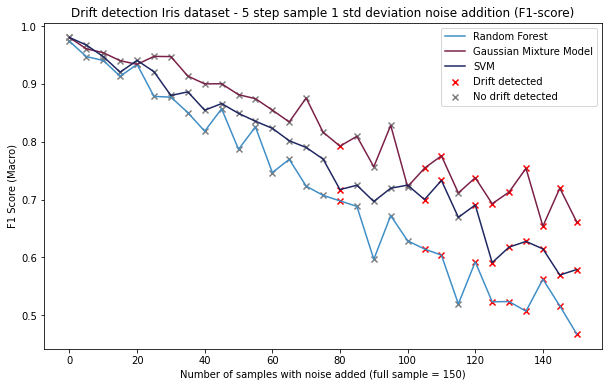

In [29]:
plt.figure(figsize=(10,6))

drift_idx = [i for idx, i in enumerate(range(0,X.shape[0]+1,step_size)) if bool(is_drift[idx])]
no_drift_idx = [i for idx, i in enumerate(range(0,X.shape[0]+1,step_size)) if not bool(is_drift[idx])]

drift_rf = [i for idx, i in enumerate(rf_predictions) if bool(is_drift[idx])]
drift_gmm = [i for idx, i in enumerate(gmm_predictions) if bool(is_drift[idx])]
drift_svm = [i for idx, i in enumerate(svm_predictions) if bool(is_drift[idx])]

no_drift_rf = [i for idx, i in enumerate(rf_predictions) if not bool(is_drift[idx])]
no_drift_gmm = [i for idx, i in enumerate(gmm_predictions) if not bool(is_drift[idx])]
no_drift_svm = [i for idx, i in enumerate(svm_predictions) if not bool(is_drift[idx])]

plt.plot(range(0,X.shape[0]+1,step_size), rf_predictions, label="Random Forest", color="#408ec6")
plt.scatter(drift_idx, drift_rf, color="red", marker="x", label="Drift detected")
plt.scatter(no_drift_idx, no_drift_rf, color="grey", marker="x", label="No drift detected")

plt.plot(range(0,X.shape[0]+1,step_size), gmm_predictions, label="Gaussian Mixture Model", color="#7a2048")
plt.scatter(drift_idx, drift_gmm, color="red", marker="x")
plt.scatter(no_drift_idx, no_drift_gmm, color="grey", marker="x")

plt.plot(range(0,X.shape[0]+1,step_size), svm_predictions, label="SVM", color="#1e2761")
plt.scatter(drift_idx, drift_svm, color="red", marker="x")
plt.scatter(no_drift_idx, no_drift_svm, color="grey", marker="x")

plt.legend()
plt.title("Drift detection Iris dataset - 5 step sample 1 std deviation noise addition (F1-score)")
plt.xlabel("Number of samples with noise added (full sample = 150)")
plt.ylabel("F1 Score (Macro)")

Text(0, 0.5, 'ROC AUC')

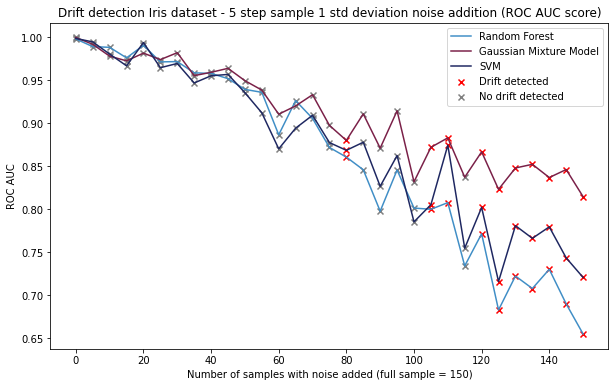

In [30]:
plt.figure(figsize=(10,6))

drift_idx = [i for idx, i in enumerate(range(0,X.shape[0]+1,step_size)) if bool(is_drift[idx])]
no_drift_idx = [i for idx, i in enumerate(range(0,X.shape[0]+1,step_size)) if not bool(is_drift[idx])]

drift_rf = [i for idx, i in enumerate(rf_rocauc) if bool(is_drift[idx])]
drift_gmm = [i for idx, i in enumerate(gmm_rocauc) if bool(is_drift[idx])]
drift_svm = [i for idx, i in enumerate(svm_rocauc) if bool(is_drift[idx])]

no_drift_rf = [i for idx, i in enumerate(rf_rocauc) if not bool(is_drift[idx])]
no_drift_gmm = [i for idx, i in enumerate(gmm_rocauc) if not bool(is_drift[idx])]
no_drift_svm = [i for idx, i in enumerate(svm_rocauc) if not bool(is_drift[idx])]

plt.plot(range(0,X.shape[0]+1,step_size), rf_rocauc, label="Random Forest", color="#408ec6")
plt.scatter(drift_idx, drift_rf, color="red", marker="x", label="Drift detected")
plt.scatter(no_drift_idx, no_drift_rf, color="grey", marker="x", label="No drift detected")

plt.plot(range(0,X.shape[0]+1,step_size), gmm_rocauc, label="Gaussian Mixture Model", color="#7a2048")
plt.scatter(drift_idx, drift_gmm, color="red", marker="x")
plt.scatter(no_drift_idx, no_drift_gmm, color="grey", marker="x")

plt.plot(range(0,X.shape[0]+1,step_size), svm_rocauc, label="SVM", color="#1e2761")
plt.scatter(drift_idx, drift_svm, color="red", marker="x")
plt.scatter(no_drift_idx, no_drift_svm, color="grey", marker="x")

plt.legend()
plt.title("Drift detection Iris dataset - 5 step sample 1 std deviation noise addition (ROC AUC score)")
plt.xlabel("Number of samples with noise added (full sample = 150)")
plt.ylabel("ROC AUC")

#### What we can see

It's recommended to run it a few times (or even put it into a loop and average, if you're ambitious!), but you will generally see several common themes:

- The first drift is, usually, detected when >80 of the samples have noise added in. It's usually once half the samples have noise included that KSDrift flags.
- GMM tends to always outperform the other two models, thus handling drift the best.
- Random forest performs the worst, thus handling drift badly.
- You'll often see on some occasions that performance can be lower than previous tests, but drift is not flagged.
- More sample items that have drifted means, on average, worse performance for f1-score.

We get a similar pattern for both of our chosen metrics, with the underlying message being that the more of your data that has drifted, the worse your model will perform!

This is great, but we still do run into a problem - mainly that in some situations drift might be present but performance can still be acceptable. It's important to underline that **drift detection is not a magic bullet** and you should always look to see how it performs on the given data. Take for example the GMM, if you're only interested when ROC AUC drops very low (0.6), then it's likely you'll see a number of occasions (if not all) where it never hits this, but drift is detected. Based on the above, if you take the word of the KS drift solely to determine when the model will need retraining, then it's likely you'll be doing it as a high cost, as although there is drift in the data, the model is still performing well enough by our own standards (ROC AUC > 0.6).

A reasonable solution might be to use drift as an indicator that a new (small) test set should be labelled and then check your core metrics if this is at all possible.

#### Let's increase the noise with plus/minus 2 standard deviations

Apologies, as this code might make things a bit messy as it's a copy and paste job from above! However, I have changed the names of the lists if you want to do any comparing of the scores. Before we added some noise in which was 1 standard deviation. If you don't know much about a normal distribution, then ~68% of the data lies within one standard deviation of the mean. Minus or add 1 standard deviation to a number, and there's a good chance that the new value will still be within the area of the distribution. However, if we add or minus 2 standard deviations, then the possibility of the new number falling within the distribution curve is diminished.

As a simple example, say we have a normal distribution with a mean of 4 and a standard deviation of 1. With normal distributions, 99.7% of the data sits within 3 standard deviations either side of the mean. So, if we just round that up for the sake of simplicity, we're saying that all the data is within 1 and 7.

Below, an initial value of 5.3 is plotted in green. The yellow shows where the value sits with + 1 std deviation from the mean, while the red shows +2 std deviation from the mean. Distribution discussion is out of scope for this, but as a note you get the occurrence of values from this plot by getting the area under the curve between two points. You can see there is more area covered between the original and the + 1 std deviation (from eye alone, I'd say this covers roughly 20% of values) compared to the area between +1 and +2 standard deviations (from eye, possibly 5% of values). You can think of this as how often your model is likely to see these values. Say you now have a sample that has these +2 standard deviations for all features in a sample - what is the likelihood it is going to have seen something similar to this in training? Not very likely...

C:\Users\rob.mccluskey\AppData\Local\Continuum\anaconda3\envs\modelmonitor\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Normal distribution value change example')

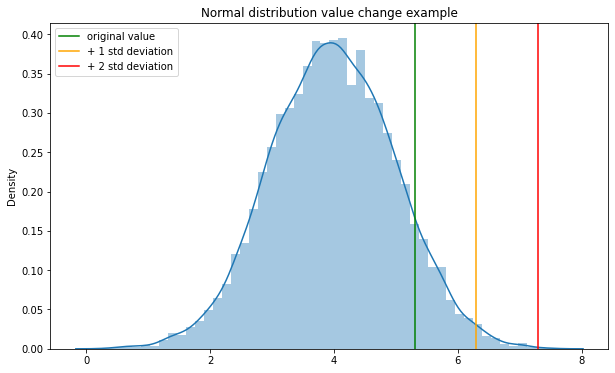

In [65]:
plt.figure(figsize=(10,6))

norm_dist = np.random.normal(loc=4,scale=1,size=10000)
sns.distplot(norm_dist)
plt.axvline(x=5.3, label="original value", color="green")
plt.axvline(x=6.3, label="+ 1 std deviation", color="orange")
plt.axvline(x=7.3, label="+ 2 std deviation", color="red")

plt.legend()
plt.title("Normal distribution value change example")

In [37]:
step_size = 5

noise = np.std(X, axis=0)
sample_one_X, sample_one_y = gmm.sample(X.shape[0])

gmm_predictions_twostd = []
rf_predictions_twostd = []
svm_predictions_twostd = []

gmm_rocauc_twostd = []
rf_rocauc_twostd = []
svm_rocauc_twostd = []

is_drift_twostd = []

cd = KSDrift(
    p_val=0.05,
    X_ref=X,
    preprocess_X_ref=False,
    preprocess_fn=fake_transform,
    alternative='two-sided',
    data_type="tabular",
)

for change_size in range(0,X.shape[0]+1,step_size):
    if change_size > 0:
        noise_idx = np.random.choice(range(0,X.shape[0]), size=change_size, replace=False)
    
        no_noise_mask = np.ones(X.shape[0]).astype(bool)
        no_noise_mask[noise_idx] = False
        noise_mask = np.zeros(X.shape[0]).astype(bool)
        noise_mask[noise_idx] = True

        ### split sample ###
        X_noise = sample_one_X[noise_mask]
        y_noise = sample_one_y[noise_mask]

        X_keep = sample_one_X[no_noise_mask]
        y_keep = sample_one_y[no_noise_mask]
        
        ### add noise ###
        duplicate_std = np.tile(noise, (change_size,1))
        plus_minus = np.random.choice([-1,1], size=(change_size, 4))
        X_noise = X_noise + ((duplicate_std*2) * plus_minus)

        new_X = np.concatenate((X_keep, X_noise), axis=0)
        new_X[new_X <0] = 0.01 ## no minus vals
        new_y = np.concatenate((y_keep, y_noise), axis=0)
    else:
        new_X = sample_one_X
        new_y = sample_one_y
    
    gmm_pred = f1_score(new_y, gmm.predict(new_X), average="macro")
    gmm_predictions_twostd.append(gmm_pred)
    
    gmm_rocauc_twostd.append(roc_auc_score(new_y, gmm.predict_proba(new_X), multi_class='ovr'))
    
    rf_pred = f1_score(new_y, rf.predict(new_X), average="macro")
    rf_predictions_twostd.append(rf_pred)
    
    rf_rocauc_twostd.append(roc_auc_score(new_y, rf.predict_proba(new_X), multi_class='ovr'))
    
    svm_pred = f1_score(new_y, svm.predict(new_X), average="macro")
    svm_predictions_twostd.append(svm_pred)
    
    svm_rocauc_twostd.append(roc_auc_score(new_y, svm.predict_proba(new_X), multi_class='ovr'))
    
    is_drift_twostd.append(cd.predict(new_X)['data']['is_drift'])

Text(0, 0.5, 'F1 Score (Macro)')

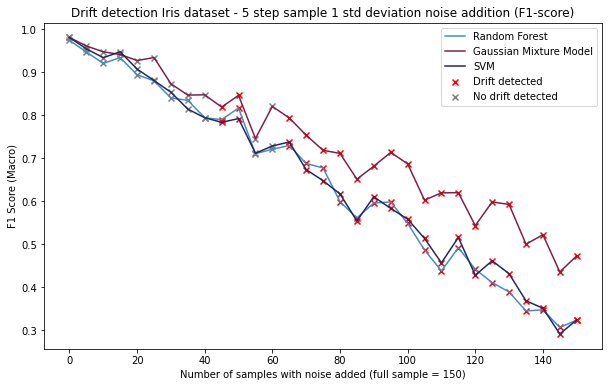

In [40]:
plt.figure(figsize=(10,6))

drift_idx = [i for idx, i in enumerate(range(0,X.shape[0]+1,step_size)) if bool(is_drift_twostd[idx])]
no_drift_idx = [i for idx, i in enumerate(range(0,X.shape[0]+1,step_size)) if not bool(is_drift_twostd[idx])]

drift_rf = [i for idx, i in enumerate(rf_predictions_twostd) if bool(is_drift_twostd[idx])]
drift_gmm = [i for idx, i in enumerate(gmm_predictions_twostd) if bool(is_drift_twostd[idx])]
drift_svm = [i for idx, i in enumerate(svm_predictions_twostd) if bool(is_drift_twostd[idx])]

no_drift_rf = [i for idx, i in enumerate(rf_predictions_twostd) if not bool(is_drift_twostd[idx])]
no_drift_gmm = [i for idx, i in enumerate(gmm_predictions_twostd) if not bool(is_drift_twostd[idx])]
no_drift_svm = [i for idx, i in enumerate(svm_predictions_twostd) if not bool(is_drift_twostd[idx])]

plt.plot(range(0,X.shape[0]+1,step_size), rf_predictions_twostd, label="Random Forest", color="#408ec6")
plt.scatter(drift_idx, drift_rf, color="red", marker="x", label="Drift detected")
plt.scatter(no_drift_idx, no_drift_rf, color="grey", marker="x", label="No drift detected")

plt.plot(range(0,X.shape[0]+1,step_size), gmm_predictions_twostd, label="Gaussian Mixture Model", color="#7a2048")
plt.scatter(drift_idx, drift_gmm, color="red", marker="x")
plt.scatter(no_drift_idx, no_drift_gmm, color="grey", marker="x")

plt.plot(range(0,X.shape[0]+1,step_size), svm_predictions_twostd, label="SVM", color="#1e2761")
plt.scatter(drift_idx, drift_svm, color="red", marker="x")
plt.scatter(no_drift_idx, no_drift_svm, color="grey", marker="x")

plt.legend()
plt.title("Drift detection Iris dataset - 5 step sample 2 std deviation noise addition (F1-score)")
plt.xlabel("Number of samples with noise added (full sample = 150)")
plt.ylabel("F1 Score (Macro)")

Text(0, 0.5, 'ROC AUC')

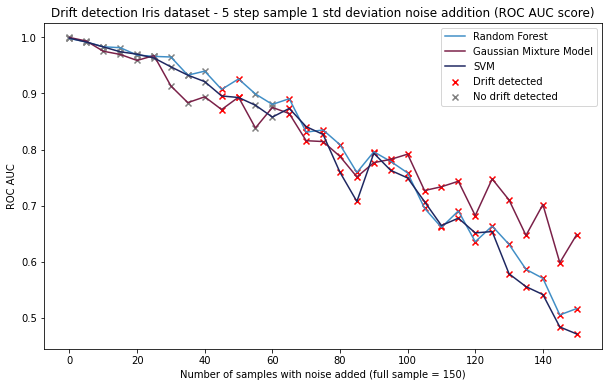

In [67]:
plt.figure(figsize=(10,6))

drift_idx = [i for idx, i in enumerate(range(0,X.shape[0]+1,step_size)) if bool(is_drift_twostd[idx])]
no_drift_idx = [i for idx, i in enumerate(range(0,X.shape[0]+1,step_size)) if not bool(is_drift_twostd[idx])]

drift_rf = [i for idx, i in enumerate(rf_rocauc_twostd) if bool(is_drift_twostd[idx])]
drift_gmm = [i for idx, i in enumerate(gmm_rocauc_twostd) if bool(is_drift_twostd[idx])]
drift_svm = [i for idx, i in enumerate(svm_rocauc_twostd) if bool(is_drift_twostd[idx])]

no_drift_rf = [i for idx, i in enumerate(rf_rocauc_twostd) if not bool(is_drift_twostd[idx])]
no_drift_gmm = [i for idx, i in enumerate(gmm_rocauc_twostd) if not bool(is_drift_twostd[idx])]
no_drift_svm = [i for idx, i in enumerate(svm_rocauc_twostd) if not bool(is_drift_twostd[idx])]

plt.plot(range(0,X.shape[0]+1,step_size), rf_rocauc_twostd, label="Random Forest", color="#408ec6")
plt.scatter(drift_idx, drift_rf, color="red", marker="x", label="Drift detected")
plt.scatter(no_drift_idx, no_drift_rf, color="grey", marker="x", label="No drift detected")

plt.plot(range(0,X.shape[0]+1,step_size), gmm_rocauc_twostd, label="Gaussian Mixture Model", color="#7a2048")
plt.scatter(drift_idx, drift_gmm, color="red", marker="x")
plt.scatter(no_drift_idx, no_drift_gmm, color="grey", marker="x")

plt.plot(range(0,X.shape[0]+1,step_size), svm_rocauc_twostd, label="SVM", color="#1e2761")
plt.scatter(drift_idx, drift_svm, color="red", marker="x")
plt.scatter(no_drift_idx, no_drift_svm, color="grey", marker="x")

plt.legend()
plt.title("Drift detection Iris dataset - 5 step sample 1 std deviation noise addition (ROC AUC score)")
plt.xlabel("Number of samples with noise added (full sample = 150)")
plt.ylabel("ROC AUC")

The above shows that not all noise is equal! Again, you can run a few more times, but what you'll likely see is:

- Drift is detected much quicker in terms of sample numbers that have been altered.
- Performance also drops faster (but this should be expected!)
- GMM is still doing its best to handle the drift and performs best!

One thing to consider is what sort of noise you'll expect in your data, as it may help you better prepare for the course of action you should take. For example, is there a day where things might suddenly change your data, such as a sudden stock market crash (for predicting stock prices)? Or can you expect a slow shift, such as the previously mentioned inflation?

#### Adding noise to particular features

A common scenario for covariate shift is that particular features drift rather than all features of a sample. For example, in terms of detecting credit card fraud, the amounts may suffer from inflation, but the dates of transactions may not alter in distribution too much (for example, you might continue to see more credit card transactions around Christmas time). On top of this, you always need to remember that not all features are equally important. The random forest can give an example of this with its built-in `feature_importances_` class function:

In [133]:
rf.feature_importances_

array([0.10612762, 0.02167809, 0.43612951, 0.43606478])

These can be interpreted as percentages of importance. The random forest is relying more-so on the last two features to make its predictions rather than the first two. The 2nd feature holds very little importance in determining predictions. In theory, this means that drift in the 2nd feature is not likely to impact model performance as much as drift present in the 3rd or 4th feature would. Please note, that this just displays the importance for the random forest model, and these figures are not a guarantee of how other models will apply importance to features.

#### Adding noise to the third feature (big importance)

Although we mentioned that not all models will apply the same importance as the figures above, we can use them as a guide, and can put some focus on how the Random Forest reacts to different levels of noise. We can look at the 3rd feature, which the Random Forest tells us is of great importance to decision making. Changes in this should dramatically impact the model.

Compared to the sample experiments, we'll set this up a bit differently in that we'll gradually add different levels of noise to the feature. In order to get better coverage, we'll add/minus half a standard deviation in every iteration until we reach 4 standard deviations from the mean (which should push a lot of things out of the distribution). We start with data that has no noise.

In [212]:
curr_feat = 2

sample_one_X, sample_one_y = gmm.sample(X.shape[0])

rf_feat_f1 = []
rf_feat_rocauc = []

gmm_feat_f1 = []
gmm_feat_rocauc = []

svm_feat_f1 = []
svm_feat_rocauc = []

is_drift_feat = []

cd = KSDrift(
    p_val=0.05,
    X_ref=X,
    preprocess_X_ref=False,
    preprocess_fn=fake_transform,
    alternative='two-sided',
    data_type="tabular",
)

### Do with no noise first ###

noise_move = np.arange(0,4.5,0.5)

for i in noise_move:
    noise_val = X[:,curr_feat].std()*i
    X_feat_noise = X.copy()
    plus_minus = np.random.choice([-1,1], size=X.shape[0])
    noise = plus_minus*noise_val
    
    X_feat_chg = sample_one_X.copy()
    
    X_feat_chg[:,curr_feat] = sample_one_X[:,curr_feat] + noise
    X_feat_chg[X_feat_chg < 0] = 0.01
    
    rf_pred = f1_score(sample_one_y, rf.predict(X_feat_chg), average="macro")
    rf_feat_f1.append(rf_pred)
    
    rf_feat_rocauc.append(roc_auc_score(sample_one_y, rf.predict_proba(X_feat_chg), multi_class='ovr'))
    
    gmm_pred = f1_score(sample_one_y, gmm.predict(X_feat_chg), average="macro")
    gmm_feat_f1.append(gmm_pred)
    
    gmm_feat_rocauc.append(roc_auc_score(sample_one_y, gmm.predict_proba(X_feat_chg), multi_class='ovr'))
    
    svm_pred = f1_score(sample_one_y, svm.predict(X_feat_chg), average="macro")
    svm_feat_f1.append(svm_pred)
    
    svm_feat_rocauc.append(roc_auc_score(sample_one_y, svm.predict_proba(X_feat_chg), multi_class='ovr'))
    
    is_drift_feat.append(cd.predict(X_feat_chg)['data']['is_drift'])

Text(0, 0.5, 'F1 score')

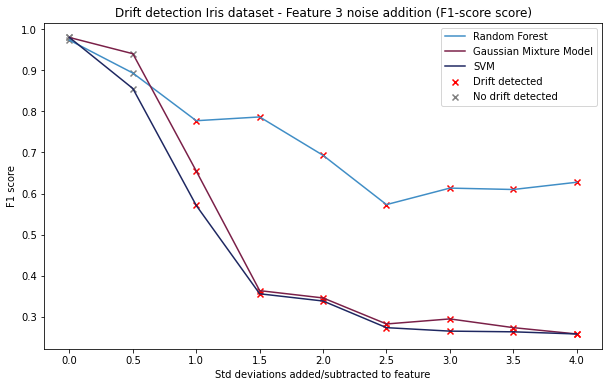

In [213]:
plt.figure(figsize=(10,6))

drift_idx = [i for idx, i in enumerate(noise_move) if bool(is_drift_feat[idx])]
no_drift_idx = [i for idx, i in enumerate(noise_move) if not bool(is_drift_feat[idx])]

drift_rf = [i for idx, i in enumerate(rf_feat_f1) if bool(is_drift_feat[idx])]
drift_gmm = [i for idx, i in enumerate(gmm_feat_f1) if bool(is_drift_feat[idx])]
drift_svm = [i for idx, i in enumerate(svm_feat_f1) if bool(is_drift_feat[idx])]

no_drift_rf = [i for idx, i in enumerate(rf_feat_f1) if not bool(is_drift_feat[idx])]
no_drift_gmm = [i for idx, i in enumerate(gmm_feat_f1) if not bool(is_drift_feat[idx])]
no_drift_svm = [i for idx, i in enumerate(svm_feat_f1) if not bool(is_drift_feat[idx])]

plt.plot(noise_move, rf_feat_f1, label="Random Forest", color="#408ec6")
plt.scatter(drift_idx, drift_rf, color="red", marker="x", label="Drift detected")
plt.scatter(no_drift_idx, no_drift_rf, color="grey", marker="x", label="No drift detected")

plt.plot(noise_move, gmm_feat_f1, label="Gaussian Mixture Model", color="#7a2048")
plt.scatter(drift_idx, drift_gmm, color="red", marker="x")
plt.scatter(no_drift_idx, no_drift_gmm, color="grey", marker="x")

plt.plot(noise_move, svm_feat_f1, label="SVM", color="#1e2761")
plt.scatter(drift_idx, drift_svm, color="red", marker="x")
plt.scatter(no_drift_idx, no_drift_svm, color="grey", marker="x")

plt.legend()
plt.title("Drift detection Iris dataset - Feature 3 noise addition (F1-score score)")
plt.xlabel("Std deviations added/subtracted to feature")
plt.ylabel("F1 score")

Text(0, 0.5, 'ROC AUC')

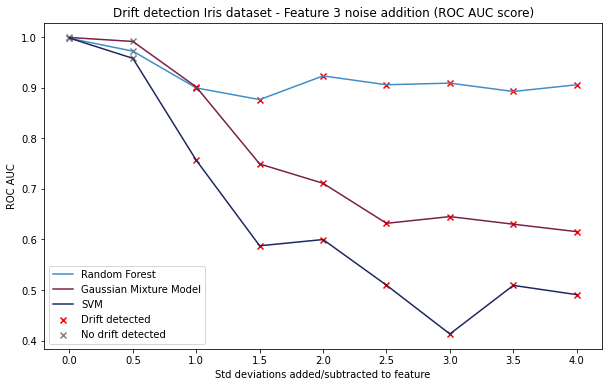

In [218]:
plt.figure(figsize=(10,6))

drift_idx = [i for idx, i in enumerate(noise_move) if bool(is_drift_feat[idx])]
no_drift_idx = [i for idx, i in enumerate(noise_move) if not bool(is_drift_feat[idx])]

drift_rf = [i for idx, i in enumerate(rf_feat_rocauc) if bool(is_drift_feat[idx])]
drift_gmm = [i for idx, i in enumerate(gmm_feat_rocauc) if bool(is_drift_feat[idx])]
drift_svm = [i for idx, i in enumerate(svm_feat_rocauc) if bool(is_drift_feat[idx])]

no_drift_rf = [i for idx, i in enumerate(rf_feat_rocauc) if not bool(is_drift_feat[idx])]
no_drift_gmm = [i for idx, i in enumerate(gmm_feat_rocauc) if not bool(is_drift_feat[idx])]
no_drift_svm = [i for idx, i in enumerate(svm_feat_rocauc) if not bool(is_drift_feat[idx])]

plt.plot(noise_move, rf_feat_rocauc, label="Random Forest", color="#408ec6")
plt.scatter(drift_idx, drift_rf, color="red", marker="x", label="Drift detected")
plt.scatter(no_drift_idx, no_drift_rf, color="grey", marker="x", label="No drift detected")

plt.plot(noise_move, gmm_feat_rocauc, label="Gaussian Mixture Model", color="#7a2048")
plt.scatter(drift_idx, drift_gmm, color="red", marker="x")
plt.scatter(no_drift_idx, no_drift_gmm, color="grey", marker="x")

plt.plot(noise_move, svm_feat_rocauc, label="SVM", color="#1e2761")
plt.scatter(drift_idx, drift_svm, color="red", marker="x")
plt.scatter(no_drift_idx, no_drift_svm, color="grey", marker="x")

plt.legend()
plt.title("Drift detection Iris dataset - Feature 3 noise addition (ROC AUC score)")
plt.xlabel("Std deviations added/subtracted to feature")
plt.ylabel("ROC AUC")

There's quite a lot to unpack here, most notably that a single standard deviation (or if you run it sometimes it might be half a standard deviation!) flags that you have drift in your data. However, we again see the difference in model performance - when we talk about a single feature shifting it is actually the random forest that handles this best, when it performed so poorly for sample changes! SVM, on the other hand, dips dramatically in performance.

It does make sense that this flags after just 1 standard deviation though. Remember the previous experiment where we incrementally changed the values by 1 standard deviation? That is just happening here to one feature, but to the entire 150 sample.

#### Adding noise to the second feature (little importance)

Let's do this again, but instead choose the 2nd feature, which our random forest tells us is not important in its decision making. We'll perform the same incremental noise inclusion to the feature, starting with no noise and ending with 4 standard deviations.

In [219]:
curr_feat = 1

sample_one_X, sample_one_y = gmm.sample(X.shape[0])

rf_feat_f1 = []
rf_feat_rocauc = []

gmm_feat_f1 = []
gmm_feat_rocauc = []

svm_feat_f1 = []
svm_feat_rocauc = []

is_drift_feat = []

cd = KSDrift(
    p_val=0.05,
    X_ref=X,
    preprocess_X_ref=False,
    preprocess_fn=fake_transform,
    alternative='two-sided',
    data_type="tabular",
)

### Do with no noise first ###

noise_move = np.arange(0,4.5,0.5)

for i in noise_move:
    noise_val = X[:,curr_feat].std()*i
    X_feat_noise = X.copy()
    plus_minus = np.random.choice([-1,1], size=X.shape[0])
    noise = plus_minus*noise_val
    
    X_feat_chg = sample_one_X.copy()
    
    X_feat_chg[:,curr_feat] = sample_one_X[:,curr_feat] + noise
    X_feat_chg[X_feat_chg < 0] = 0.01
    
    rf_pred = f1_score(sample_one_y, rf.predict(X_feat_chg), average="macro")
    rf_feat_f1.append(rf_pred)
    
    rf_feat_rocauc.append(roc_auc_score(sample_one_y, rf.predict_proba(X_feat_chg), multi_class='ovr'))
    
    gmm_pred = f1_score(sample_one_y, gmm.predict(X_feat_chg), average="macro")
    gmm_feat_f1.append(gmm_pred)
    
    gmm_feat_rocauc.append(roc_auc_score(sample_one_y, gmm.predict_proba(X_feat_chg), multi_class='ovr'))
    
    svm_pred = f1_score(sample_one_y, svm.predict(X_feat_chg), average="macro")
    svm_feat_f1.append(svm_pred)
    
    svm_feat_rocauc.append(roc_auc_score(sample_one_y, svm.predict_proba(X_feat_chg), multi_class='ovr'))
    
    is_drift_feat.append(cd.predict(X_feat_chg)['data']['is_drift'])

(0.8, 1.02)

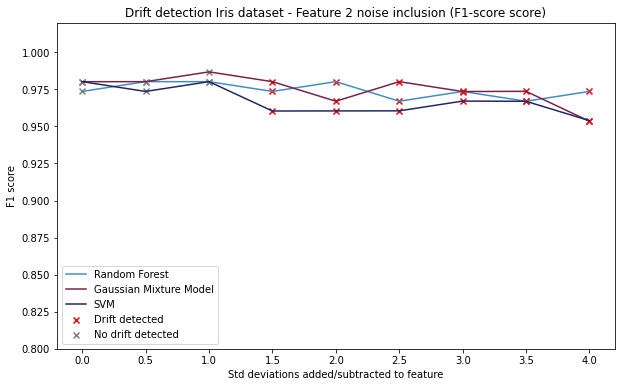

In [224]:
plt.figure(figsize=(10,6))

drift_idx = [i for idx, i in enumerate(noise_move) if bool(is_drift_feat[idx])]
no_drift_idx = [i for idx, i in enumerate(noise_move) if not bool(is_drift_feat[idx])]

drift_rf = [i for idx, i in enumerate(rf_feat_f1) if bool(is_drift_feat[idx])]
drift_gmm = [i for idx, i in enumerate(gmm_feat_f1) if bool(is_drift_feat[idx])]
drift_svm = [i for idx, i in enumerate(svm_feat_f1) if bool(is_drift_feat[idx])]

no_drift_rf = [i for idx, i in enumerate(rf_feat_f1) if not bool(is_drift_feat[idx])]
no_drift_gmm = [i for idx, i in enumerate(gmm_feat_f1) if not bool(is_drift_feat[idx])]
no_drift_svm = [i for idx, i in enumerate(svm_feat_f1) if not bool(is_drift_feat[idx])]

plt.plot(noise_move, rf_feat_f1, label="Random Forest", color="#408ec6")
plt.scatter(drift_idx, drift_rf, color="red", marker="x", label="Drift detected")
plt.scatter(no_drift_idx, no_drift_rf, color="grey", marker="x", label="No drift detected")

plt.plot(noise_move, gmm_feat_f1, label="Gaussian Mixture Model", color="#7a2048")
plt.scatter(drift_idx, drift_gmm, color="red", marker="x")
plt.scatter(no_drift_idx, no_drift_gmm, color="grey", marker="x")

plt.plot(noise_move, svm_feat_f1, label="SVM", color="#1e2761")
plt.scatter(drift_idx, drift_svm, color="red", marker="x")
plt.scatter(no_drift_idx, no_drift_svm, color="grey", marker="x")

plt.legend()
plt.title("Drift detection Iris dataset - Feature 2 noise inclusion (F1-score score)")
plt.xlabel("Std deviations added/subtracted to feature")
plt.ylabel("F1-score")
plt.ylim(0.8,1.02)

(0.8, 1.02)

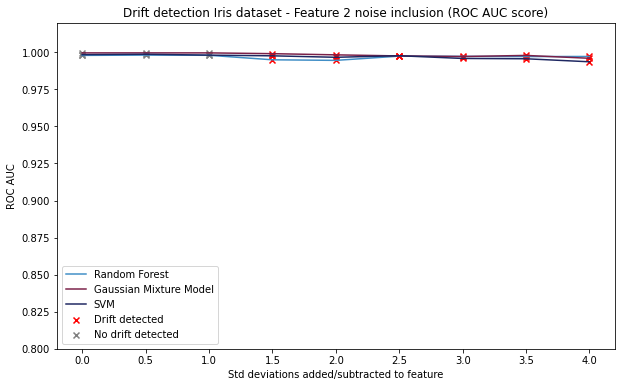

In [223]:
plt.figure(figsize=(10,6))

drift_idx = [i for idx, i in enumerate(noise_move) if bool(is_drift_feat[idx])]
no_drift_idx = [i for idx, i in enumerate(noise_move) if not bool(is_drift_feat[idx])]

drift_rf = [i for idx, i in enumerate(rf_feat_rocauc) if bool(is_drift_feat[idx])]
drift_gmm = [i for idx, i in enumerate(gmm_feat_rocauc) if bool(is_drift_feat[idx])]
drift_svm = [i for idx, i in enumerate(svm_feat_rocauc) if bool(is_drift_feat[idx])]

no_drift_rf = [i for idx, i in enumerate(rf_feat_rocauc) if not bool(is_drift_feat[idx])]
no_drift_gmm = [i for idx, i in enumerate(gmm_feat_rocauc) if not bool(is_drift_feat[idx])]
no_drift_svm = [i for idx, i in enumerate(svm_feat_rocauc) if not bool(is_drift_feat[idx])]

plt.plot(noise_move, rf_feat_rocauc, label="Random Forest", color="#408ec6")
plt.scatter(drift_idx, drift_rf, color="red", marker="x", label="Drift detected")
plt.scatter(no_drift_idx, no_drift_rf, color="grey", marker="x", label="No drift detected")

plt.plot(noise_move, gmm_feat_rocauc, label="Gaussian Mixture Model", color="#7a2048")
plt.scatter(drift_idx, drift_gmm, color="red", marker="x")
plt.scatter(no_drift_idx, no_drift_gmm, color="grey", marker="x")

plt.plot(noise_move, svm_feat_rocauc, label="SVM", color="#1e2761")
plt.scatter(drift_idx, drift_svm, color="red", marker="x")
plt.scatter(no_drift_idx, no_drift_svm, color="grey", marker="x")

plt.legend()
plt.title("Drift detection Iris dataset - Feature 2 noise inclusion (ROC AUC score)")
plt.xlabel("Std deviations added/subtracted to feature")
plt.ylabel("ROC AUC")
plt.ylim(0.8,1.02)

Please note that the Y axis runs from 0.8 to 1, with this done so you can see the slight change!

Now, something interesting is happening here. We are being told that drift can be found, but our models are all seemingly still performing well. **This shows the importance of taking care with drift methods - It is not something that is often black and white**. If you were to use this single binary flag to trigger a retrain, then it's likely that in the above situation you'd be doing so incorrectly - it would come at an unnecessary cost!

This is not to say that the drift detection is broken - it is doing exactly what it should and is telling you that there is drift in the data. Remember that it has no knowledge of metrics or feature importance. The fact of the matter is that some critical thinking is usually required alongside this flag in order to determine the best course of action.

#### Alibi-detect lets you look at the individual features instead!

You may have thought that the above results make the KSDrift quite limited and gave a big risk of raising false flags. While you do get the individual p values for the features, there is a change you can apply in the code that can give you a Boolean flag for each individual feature. Combining this with something like feature importance scores above makes this a very powerful tool, and something that can help you make better judgements.

Let's try the noise inclusion again from the previous example with the 2nd column - which has little importance. This time, when we call `predict()` on our drift detector object, we can include the argument `drift_type="feature"`. This will return the same output as normal, but it'll return an array of results the same size as the n features in your data set.

In [226]:
cd = KSDrift(
    p_val=0.05,
    X_ref=X,
    preprocess_X_ref=False,
    preprocess_fn=fake_transform,
    alternative='two-sided',
    data_type="tabular",
)

noise_val = X[:,curr_feat].std()*3
samp_X_featdrift, _ = gmm.sample(X.shape[0])

plus_minus = np.random.choice([-1,1], size=X.shape[0])
noise = plus_minus*noise_val
    
samp_X_featdrift[:,1] = samp_X_featdrift[:,1] + noise
samp_X_featdrift[samp_X_featdrift < 0] = 0.01

cd.predict(samp_X_featdrift, drift_type="feature")

{'data': {'is_drift': array([0, 1, 0, 0]),
  'distance': array([0.08      , 0.43333334, 0.11333334, 0.10666667], dtype=float32),
  'p_val': array([6.9285506e-01, 2.5513998e-13, 2.6945195e-01, 3.3667281e-01],
        dtype=float32),
  'threshold': 0.05},
 'meta': {'name': 'KSDrift',
  'detector_type': 'offline',
  'data_type': 'tabular'}}

Say we've pre-emptively determined feature importance before going live and done some noise experiments that shows the feature doesn't impact our performance much. We can now make a more confident decision that we don't need to pull our live model, as the only drift detection is in our non-important feature. This saves a lot of unnecessary work from being done! 

### Summary

In summary, we can see that the KS drift technique is useful for detecting when your models are potentially in trouble, but caution must be exercised with them and you must **always consider your own needs and thresholds, as well as the feature importance**. 

This library is something that can effectively be used before deployment if you have a number of tests set up, similar to how you apply unit tests for code. While this was just an introduction onto its effectiveness, we didn't even cover some of the other things such as threshold application and the distance metrics produced and if they can be used to further your decision.

From our original goals, we can say:

##### On average, at what point is drift detection detected and how does that relate to metric performance?
This is hard to answer and depends on what you are seeing. Indeed, one of the most important factors is the feature itself that has drifted. However, we do generally see that there is some performance drop when drift is flagged. Users should keep in mind that this is not a definitive answer as to whether their model is now performing at a standard that is no longer acceptable - this depends entirely on their set up.

##### Do some models handle drift better than others?
All models seen here have different levels of performance impacts depending on the magnitude of the drift and the type. It is recommended to simulate some noise into your data before you deploy so you can get an idea of impact on your own particular model. While we haven't talked about the distance metrics too much, these could also be used to give you a prediction of what the current performance of your model might be.

##### How do different types of noise impact drift and performance?
You should consider where noise appears in your data and what the ultimate impact could be. For example, if a feature has drifted, then you need to consider its importance. If novel sample items are presented, then it needs to be considered the magnitude of change and how many of them have actually drifted. You should always try to predict what sort of drift you might see and make preparations for it!